# Các Thuật Toán Nền Tảng và Hạn Chế

Phần này trình bày các thuật toán gradient descent nền tảng và những hạn chế khi áp dụng vào các bài toán thực tế, đặc biệt trong bối cảnh dữ liệu thưa (sparse data) như đối với bộ dữ liệu RCV1.

## Giới thiệu bộ dữ liệu RCV1

### Giới thiệu Tổng quan

**RCV1 (Reuters Corpus Volume 1)** là bộ dữ liệu chuẩn (benchmark dataset) được sử dụng rộng rãi trong nghiên cứu Machine Learning, đặc biệt cho các bài toán phân loại văn bản và phân tích dữ liệu thưa (sparse data analysis).

Bộ dữ liệu này được thu thập và công bố bởi Reuters, bao gồm hơn 800,000 bài báo tiếng Anh được xuất bản bởi hãng thông tấn Reuters trong khoảng thời gian từ tháng 8/1996 đến 8/1997. Mỗi bài báo được gán nhãn với một hoặc nhiều chủ đề từ hệ thống phân loại dạng phân cấp của Reuters.

### Thống kê đặc trưng của bộ dữ liệu RCV1

| Đặc điểm | Training Set | Test Set | Tổng |
|---|---|---|---|
| **Số documents** | 23,149 | 781,265 | 804,414 |
| **Số features (terms)** | 47,236 | 47,236 | 47,236 |
| **Số topics/categories** | 103 | 103 | 103 |
| **Kích thước ma trận** | 23,149 $\times$ 47,236 | 781,265 $\times$ 47,236 | - |
| **Số phần tử khác 0** | ~1,500,000 | ~49,000,000 | ~50,500,000 |
| **Sparsity (độ thưa)** | 99.86% | 99.87% | ~99.87% |

### Biểu diễn Dữ liệu

Feature Representation: Bag-of-Words (BoW) với TF-IDF weighting.

Mỗi document $d$ được biểu diễn bởi vector:

$$\mathbf{x}_d = [x_1, x_2, \ldots, x_{47236}]$$

trong đó:

$$x_i = \text{TF-IDF}(term_i, d) = \text{TF}(term_i, d) \times \text{IDF}(term_i)$$

với:

- $\text{TF}(term_i, d)$: Term Frequency — tần suất xuất hiện của từ $i$ trong document $d$
- $\text{IDF}(term_i) = \log \frac{N}{df(term_i)}$: Inverse Document Frequency
  - $N$: Tổng số documents
  - $df(term_i)$: Số documents chứa $term_i$

**Đặc điểm sparse:**

- Mỗi document thường chỉ chứa khoảng 200–400 từ khác nhau.
- Trong 47,236 features, chỉ khoảng 0.5–1% có giá trị khác 0 cho mỗi document.
- Phần lớn (khoảng 99%) các phần tử trong vector có giá trị bằng 0.

### Dữ liệu thưa (Sparse Features) là gì?

Dữ liệu thưa là dữ liệu mà hầu hết các giá trị là 0, các features xuất hiện không thường xuyên (infrequent features). Đây là đặc trưng phổ biến trong nhiều bài toán thực tế:

- **Xử lý ngôn ngữ tự nhiên (NLP):** Trong mô hình Bag-of-Words, từ "preconditioning" xuất hiện ít hơn rất nhiều so với từ "learning".
- **Quảng cáo tính toán (Computational Advertising):** Các sản phẩm/quảng cáo cụ thể chỉ được một nhóm nhỏ người dùng quan tâm.
- **Hệ thống gợi ý (Collaborative Filtering):** Mỗi user chỉ tương tác với một phần rất nhỏ trong tổng số items.

## Gradient Descent (GD)

**Ý tưởng:** Cập nhật tham số mô hình dựa trên gradient của hàm mất mát tính trên toàn bộ tập dữ liệu training.

**Công thức cập nhật:**

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x})$$

Trong đó:

- $\mathbf{x}$ là vector tham số cần tối ưu
- $\eta$ là learning rate (tốc độ học)
- $\nabla f(\mathbf{x})$ là gradient của hàm mục tiêu tại điểm $\mathbf{x}$

**Vấn đề:**

- Chi phí tính toán cực lớn: phải duyệt qua toàn bộ $n$ mẫu để tính gradient cho mỗi bước cập nhật duy nhất.
- Tốn bộ nhớ khi $n$ lớn (như RCV1 với 804,414 mẫu $\times$ 47,236 features).
- Tốc độ cập nhật chậm (1 lần/epoch), không tận dụng được random fluctuation.

In [ ]:
def train_gd_visualize(X_sparse, y_tensor, lr=0.5, epochs=20):
    W = torch.normal(0, 0.01, size=(n_features, 1), requires_grad=True, device=device)
    b = torch.zeros(1, requires_grad=True, device=device)
    criterion = nn.BCEWithLogitsLoss()
    epoch_losses = []

    print(f"\nStarting Training Gradient Descent (Full Batch)...")
    print(f"Total samples: {n_samples} | Updates per epoch: 1")
    print("="*70)

    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()

        linear_out = torch.sparse.mm(X_sparse, W) + b
        loss = criterion(linear_out, y_tensor)
        loss.backward()

        # Update parameters (GD update)
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()

        current_loss = loss.item()
        epoch_losses.append(current_loss)
        epoch_time = time.time() - epoch_start

        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {current_loss:.6f} | "
                  f"Time: {epoch_time:.2f}s")

        if current_loss < 1e-5:
            print(f"\n✓ Converged at epoch {epoch+1}!")
            break

    total_time = time.time() - start_time
    print("="*70)
    print(f" Training Complete!")
    print(f" Total time: {total_time:.2f}s")
    print(f" Avg time/epoch: {total_time/len(epoch_losses):.2f}s")
    print(f" Total updates: {len(epoch_losses)}")
    print(f" Final loss: {epoch_losses[-1]:.6f}")

    return epoch_losses

## Stochastic Gradient Descent (SGD)

**Ý tưởng chung:** Thay vì tính gradient trên toàn bộ dữ liệu như GD, SGD và các biến thể của nó cập nhật tham số dựa trên gradient của một phần nhỏ dữ liệu được chọn ngẫu nhiên. Điều này giúp tăng tốc độ tính toán và khả năng tổng quát hóa.

### Stochastic Gradient Descent

**Công thức cập nhật:**

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x})$$

**Trong đó:**

- $\mathbf{x}$ là vector tham số cần tối ưu
- $\eta > 0$ là learning rate (tốc độ học)
- $\nabla f_i(\mathbf{x})$ là gradient của hàm loss tại mẫu thứ $i$
- $i \in \{1, \ldots, n\}$ được chọn ngẫu nhiên từ tập training

**Đặc điểm:**

- Cập nhật rất nhanh (chỉ xử lý 1 mẫu/bước).
- Gradient dao động mạnh (high variance) do chỉ dựa vào 1 mẫu.
- Đường đi đến minimum có dạng "zigzag".
- Khả năng thoát local minima nhờ "nhiễu" ngẫu nhiên.

Device: cuda
Downloading/Loading RCV1...
Đang vẽ biểu đồ toàn bộ quá trình...
Bắt đầu Training Pure SGD (Total samples: 23149)...
Epoch 1 | Sample 0/23149 | Current Loss: 0.6843
Epoch 1 | Sample 5000/23149 | Current Loss: 0.5756
Epoch 1 | Sample 10000/23149 | Current Loss: 0.6570
Epoch 1 | Sample 15000/23149 | Current Loss: 0.5148
Epoch 1 | Sample 20000/23149 | Current Loss: 0.4095
--> Kết thúc Epoch 1
Epoch 2 | Sample 0/23149 | Current Loss: 0.4474
Epoch 2 | Sample 5000/23149 | Current Loss: 0.7594
Epoch 2 | Sample 10000/23149 | Current Loss: 0.3345
Epoch 2 | Sample 15000/23149 | Current Loss: 0.6072
Epoch 2 | Sample 20000/23149 | Current Loss: 0.8333
--> Kết thúc Epoch 2
Epoch 3 | Sample 0/23149 | Current Loss: 0.5213
Epoch 3 | Sample 5000/23149 | Current Loss: 0.3478
Epoch 3 | Sample 10000/23149 | Current Loss: 0.1534
Epoch 3 | Sample 15000/23149 | Current Loss: 0.5065
Epoch 3 | Sample 20000/23149 | Current Loss: 0.3991
--> Kết thúc Epoch 3
Epoch 4 | Sample 0/23149 | Current Loss: 0

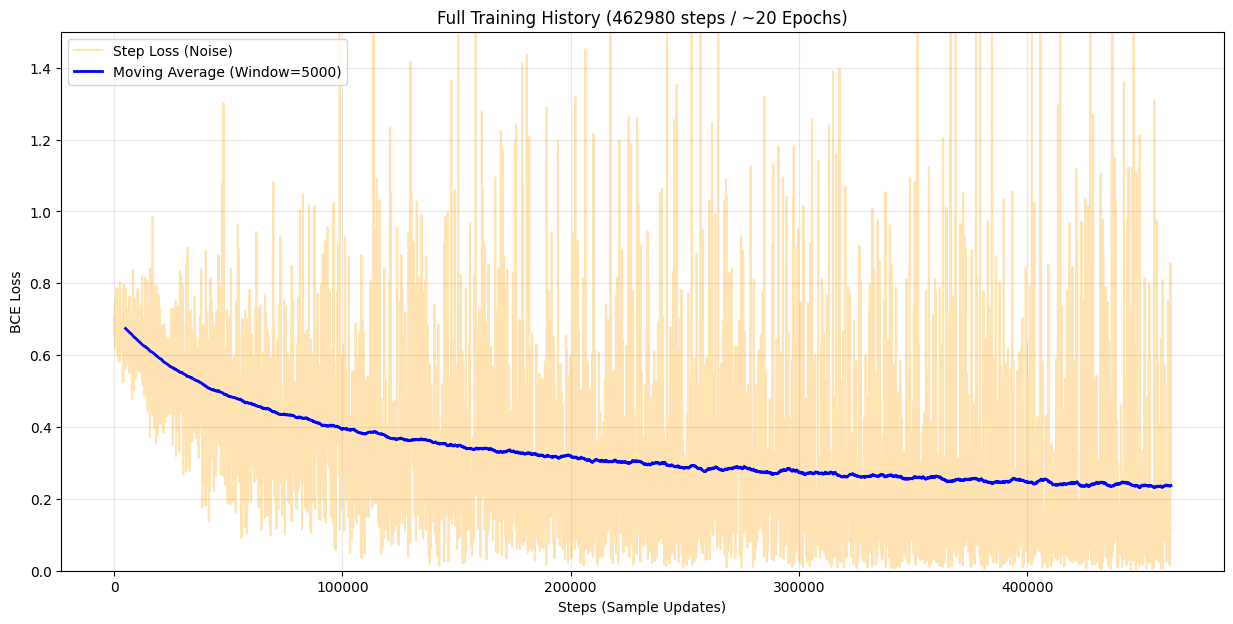

In [1]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_rcv1
import torch.nn as nn
from sklearn.datasets import clear_data_home

clear_data_home()

# 1. Setup & Load Data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print("Downloading/Loading RCV1...")
rcv1 = fetch_rcv1(subset='train')
n_samples, n_features = rcv1.data.shape

# Xử lý nhãn
topic_counts = rcv1.target.sum(axis=0)
most_frequent_topic_idx = np.argmax(topic_counts)
y_full = rcv1.target[:, most_frequent_topic_idx].toarray().ravel()
y_cpu = torch.tensor(y_full, dtype=torch.float32).view(-1, 1)

# 2. Hàm Train SGD có ghi Log và In tiến độ
def train_sgd_visualize(X_scipy, y_cpu, lr=0.01, epochs=1):
    # Khởi tạo tham số
    W = torch.normal(0, 0.01, size=(n_features, 1), requires_grad=True, device=device)
    b = torch.zeros(1, requires_grad=True, device=device)
    criterion = nn.BCEWithLogitsLoss()
    step_losses = []

    print(f"Bắt đầu Training Pure SGD (Total samples: {n_samples})...")
    start_time = time.time()

    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        for i, idx in enumerate(indices):
            # Lấy 1 mẫu (Batch size = 1)
            X_sample = torch.tensor(X_scipy[idx].toarray(), dtype=torch.float32).to(device)
            y_sample = y_cpu[idx].to(device).view(1, 1)

            # Forward & Loss
            linear_out = X_sample @ W + b
            loss = criterion(linear_out, y_sample)

            # Backward & Update
            loss.backward()
            with torch.no_grad():
                W -= lr * W.grad
                b -= lr * b.grad
                W.grad.zero_()
                b.grad.zero_()

            # Lưu lại loss
            current_loss = loss.item()
            step_losses.append(current_loss)

            # --- PHẦN BẠN CẦN: IN TIẾN ĐỘ & LOSS ---
            # In ra mỗi 1000 samples để theo dõi
            if i % 5000 == 0:
                print(f"Epoch {epoch+1} | Sample {i}/{n_samples} | Current Loss: {current_loss:.4f}")

        print(f"--> Kết thúc Epoch {epoch+1}")

    print(f"Tổng thời gian: {time.time() - start_time:.2f}s")
    return step_losses

# 3. Hàm Visualize (Vẽ biểu đồ Nhiễu vs Xu hướng)
def plot_full_training_history(losses, window_size=1000, downsample_rate=100):
    """
    Vẽ toàn bộ quá trình huấn luyện bằng cách giảm số lượng điểm vẽ (Downsampling).
    Input:
        losses: List chứa toàn bộ history (khoảng 460k điểm)
        window_size: Kích thước cửa sổ Moving Average
        downsample_rate: Vẽ 1 điểm cho mỗi n bước (để biểu đồ nhẹ hơn)
    """
    plt.figure(figsize=(15, 7))
    total_steps = len(losses)

    # 1. Vẽ Loss thực tế (Downsampling để không bị dày đặc quá)
    # Lấy bước nhảy là downsample_rate
    steps = range(0, total_steps, downsample_rate)
    sampled_losses = [losses[i] for i in steps]
    plt.plot(steps, sampled_losses, color='orange', alpha=0.3, label='Step Loss (Noise)')

    # 2. Vẽ Moving Average cho TOÀN BỘ quá trình
    # Tính trên dữ liệu gốc để chính xác, sau đó mới vẽ
    if total_steps > window_size:
        # Tính Moving Average
        moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

        # Trục x cho moving average (căn chỉnh về cuối cửa sổ)
        ma_x_axis = range(window_size-1, total_steps)

        # Downsample đường Moving Average để vẽ cho nhanh (tùy chọn)
        # Vì đường này mượt nên có thể vẽ hết hoặc downsample ít hơn
        plt.plot(ma_x_axis[::downsample_rate], moving_avg[::downsample_rate],
                color='blue', linewidth=2, label=f'Moving Average (Window={window_size})')

    plt.title(f'Full Training History ({total_steps} steps / ~{total_steps//23149} Epochs)')
    plt.xlabel('Steps (Sample Updates)')
    plt.ylabel('BCE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Giới hạn trục Y để loại bỏ các điểm nhiễu quá lớn (outliers)
    plt.ylim(0, 1.5)
    plt.show()

# --- SỬ DỤNG ---
print("Đang vẽ biểu đồ toàn bộ quá trình...")
# window_size lớn hơn (5000) để làm mượt đường xu hướng trên tập dữ liệu lớn
loss_history = train_sgd_visualize(rcv1.data, y_cpu, lr=0.01, epochs=20)
plot_full_training_history(loss_history, window_size=5000, downsample_rate=100)
# Mình để LR nhỏ (0.01) để loss đỡ bị nhảy quá cao

## Hạn Chế của SGD với Dữ liệu Thưa (Sparse Features)

**Trong bộ dữ liệu RCV1 đang sử dụng:**

- Input vector $\mathbf{x}$ có kích thước 47,236 chiều (số từ vựng).
- Tuy nhiên, mỗi văn bản chỉ chứa vài trăm từ khác 0 $\rightarrow$ độ thưa (sparsity) rất cao.
- Một số từ phổ biến (common features) xuất hiện trong hầu hết văn bản.
- Nhiều từ hiếm (rare/infrequent features) chỉ xuất hiện trong một vài văn bản.

### Phân tích Gradient với Dữ liệu Thưa

Xét mô hình tuyến tính đơn giản:

$$\hat{y} = \mathbf{w}^\top \mathbf{x}$$

Khi tính gradient của hàm mất mát $L$ theo trọng số $w_i$:

$$\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial \hat{y}} \cdot x_i$$

| Loại feature | Tần suất xuất hiện | Gradient | Tình trạng cập nhật |
|---|---|---|---|
| **Phổ biến (frequent)** | $x_i \neq 0$ thường xuyên | Khác 0 liên tục | $w_i$ được cập nhật liên tục |
| **Hiếm (infrequent)** | $x_i = 0$ hầu hết các mẫu | Bằng 0 phần lớn thời gian | $w_i$ hiếm khi được cập nhật |

### Vấn đề xảy ra với dữ liệu thưa của Learning Rate

**Vấn đề xảy ra với dữ liệu thưa của learning rate:**

1. **Với features phổ biến ($w_{\text{common}}$):**
   - Nhận gradient liên tục qua mọi iteration.
   - Learning rate giảm dần $\rightarrow$ hội tụ ổn định đến giá trị tối ưu.
   - Hoạt động ổn định.

2. **Với features hiếm ($w_{\text{rare}}$):**
   - Chỉ nhận gradient khác 0 khi feature xuất hiện (rất hiếm).
   - Khi feature cuối cùng xuất hiện, learning rate đã giảm quá nhiều.
   - Không còn đủ "lực" để cập nhật $w_i$ một cách có ý nghĩa.
   - Chưa hội tụ dù training đã kết thúc.

**Tóm lại:** Tốc độ học giảm quá chậm đối với các đặc trưng xuất hiện thường xuyên, hoặc quá nhanh đối với các đặc trưng xuất hiện không thường xuyên.

## Ví dụ với bộ dữ liệu RCV1

Phần này làm rõ cơ chế toán học khiến SGD với learning rate cố định không hiệu quả trên dữ liệu thưa, dẫn đến nhu cầu phát triển các thuật toán khác.

### Gradient trong Binary Classification với BCE Loss

Xét bài toán binary classification với logistic regression:

$$\hat{y} = \sigma(\mathbf{w}^\top \mathbf{x}) = \sigma\left(\sum_{j=1}^{d} w_j x_j\right)$$

trong đó $\sigma(z) = \frac{1}{1 + e^{-z}}$ là sigmoid activation function.

Binary Cross-Entropy Loss cho một mẫu $(\mathbf{x}, y)$ với $y \in \{0, 1\}$:

$$\ell(\mathbf{w}) = -\left[y \log(\hat{y}) + (1-y) \log(1-\hat{y})\right]$$

**Gradient theo từng tham số $w_j$:**

Áp dụng chain rule:

$$\frac{\partial \ell}{\partial w_j}
= \frac{\partial \ell}{\partial \hat{y}}
\cdot \frac{\partial \hat{y}}{\partial z}
\cdot \frac{\partial z}{\partial w_j}$$

với $z = \mathbf{w}^\top \mathbf{x}$.

Sau khi tính toán, ta có:

$$\frac{\partial \ell}{\partial w_j} = (\hat{y} - y) \cdot x_j$$

Trong đó:

- $(\hat{y} - y)$: Prediction error, phụ thuộc vào chất lượng dự đoán của mô hình.
- $\hat{y} = \sigma(\mathbf{w}^\top \mathbf{x}) \in (0, 1)$: Xác suất dự đoán.
- $y \in \{0, 1\}$: Nhãn thực tế.
- $x_j$: Giá trị feature thứ $j$ trong mẫu hiện tại.

**Ta thấy:**

$$\boxed{x_j = 0 \;\Rightarrow\; \frac{\partial \ell}{\partial w_j} = 0}$$

$\Rightarrow$ Tham số $w_j$ không nhận gradient từ mẫu này, do đó không được cập nhật.

Kết quả này độc lập với loss function. Miễn là model tuyến tính $\hat{y} = f(\mathbf{w}^\top \mathbf{x})$, gradient luôn tỷ lệ với $x_j$.

### Minh họa với ví dụ cụ thể

**Ví dụ:** Xét mini-batch chứa văn bản về doanh nghiệp (label $y=1$ cho CCAT).

Giả sử sau tokenization và TF-IDF encoding:

| Feature | TF-IDF | $x_j$ | Gradient | Cập nhật SGD |
|---|---|---|---|---|
| "company" | cao | $x_{\text{company}} = 0.8$ | $\neq 0$ | Cập nhật |
| "merger" | trung bình | $x_{\text{merger}} = 0.3$ | $\neq 0$ | Cập nhật |
| "reuters" | 0 (không có) | $x_{\text{reuters}} = 0$ | $0$ | Không cập nhật |
| "eigenvalue" | 0 (không có) | $x_{\text{eigenvalue}} = 0$ | $0$ | Không cập nhật |

**Hệ quả:**

- **Features phổ biến** ("company", "merger"): nhận gradient thường xuyên $\rightarrow$ học nhanh.
- **Features hiếm** ("reuters"): gradient = 0 ở hầu hết bước cập nhật $\rightarrow$ học rất chậm.

### Tần suất Cập nhật và Learning Rate Requirements

Giả sử trong RCV1 training set (23,149 documents):

- Feature "said": xuất hiện trong $\sim$15,000 documents (65%).
- Feature "preconditioning": xuất hiện trong $\sim$5 documents (0.02%).

**Sau 1,000 iterations SGD (random sampling):**

| Feature | Số lần nhận gradient $\neq 0$ | Magnitude tích lũy | LR lý tưởng |
|---|---|---|---|
| "said" | $\sim 650$ | Rất lớn | Nhỏ ($\sim 0.001$) |
| "reuters" | $\sim 0$ (có thể = 0) | Gần 0 | Lớn ($\sim 0.1$) |

**Dilemma với learning rate cố định $\eta$:**

$$\eta_{\text{SGD}} =
\begin{cases}
\text{Nhỏ (0.001)} & \Rightarrow w_{\text{common}} \text{ hội tụ ổn định, nhưng } w_{\text{rare}} \text{ học quá chậm hoặc không học} \\[6pt]
\text{Lớn (0.1)} & \Rightarrow w_{\text{rare}} \text{ có cơ hội học, nhưng } w_{\text{common}} \text{ dao động mạnh / diverge}
\end{cases}$$

**Minh họa cập nhật SGD:**

$$w_j^{(t+1)} = w_j^{(t)} - \eta \cdot (\hat{y}^{(t)} - y^{(t)}) \cdot x_j^{(t)}$$

- Nếu $x_j^{(t)} = 0$ (feature không xuất hiện): $w_j^{(t+1)} = w_j^{(t)}$ (không thay đổi).
- Feature hiếm: $x_j \neq 0$ chỉ trong $\sim$0.02% iterations $\rightarrow$ tổng cộng cập nhật $\ll$ 1,000 lần.
- Feature phổ biến: $x_j \neq 0$ trong $\sim$65% iterations $\rightarrow$ cập nhật $\sim$650 lần.

$\Rightarrow$ Chênh lệch 30,000x về số lần cập nhật!

### Sparse Gradient và Ảnh hưởng đến Optimization

Với một document trong RCV1 (trung bình 67 features khác 0 / 47,236 features):

$$\nabla \ell(\mathbf{w}) =
\begin{bmatrix}
g_1 \\
0 \\
0 \\
g_4 \\
\vdots \\
0
\end{bmatrix}
\quad\text{với}\quad
\|\nabla \ell\|_0 \approx 67 \ll 47236$$

Trong đó:

- $\|\nabla \ell\|_0$: số thành phần khác 0 (cardinality).
- $d = 47,236$: tổng số features.
- Sparsity: $\frac{\|\nabla \ell\|_0}{d} \approx 0.14\%$ $\rightarrow$ 99.86% gradient components = 0.

**Ảnh hưởng đến SGD update:**

$$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla \ell(\mathbf{w}^{(t)})$$

Khi gradient cực kỳ sparse:

- Chỉ $\sim$67 tham số (0.14%) được cập nhật mỗi iteration.
- 47,169 tham số còn lại (99.86%) "đứng yên".
- Tần suất cập nhật không đồng đều: features phổ biến được cập nhật hàng trăm lần, features hiếm có thể không được cập nhật lần nào.
- Magnitude cập nhật cũng không đồng đều: common features có tổng gradient tích lũy lớn hơn hàng nghìn lần so với rare features.

### So sánh với Dense Data

| Đặc điểm | Dense Data | Sparse Data (RCV1) |
|---|---|---|
| Features active/sample | $\sim$100% | $\sim$0.14% |
| Gradient sparsity | Low ($\sim$0%) | Extreme (99.86%) |
| Update frequency | Đồng đều | Rất không đồng đều |
| LR cố định | Hoạt động tốt | Thất bại |

**Kết luận:**

- Gradient thưa (sparse gradient) dẫn đến tần suất cập nhật không đồng đều giữa các tham số.
- SGD với learning rate cố định không thể cân bằng giữa:
  - Features phổ biến: cần learning rate nhỏ để tránh oscillation.
  - Features hiếm: cần learning rate lớn để học được trong thời gian hợp lý.

$\Rightarrow$ Cần cơ chế adaptive learning rate tự động điều chỉnh theo từng tham số.